In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np
import joblib    
import pickle
from sklearn.metrics import confusion_matrix, classification_report

In [13]:
IMAGE_SIZE=256
BATCH_SIZE=16
CHANNELS=3
EPOCHS=20

In [3]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "D:\Ishita\IGDTUW (CSE)\Summer Internship 2023\Potato",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 1500 files belonging to 3 classes.


In [4]:
class_names=dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset)

94

(16, 256, 256, 3)
[2 2 1 1 2 1 0 1 2 2 1 1 0 1 0 1]


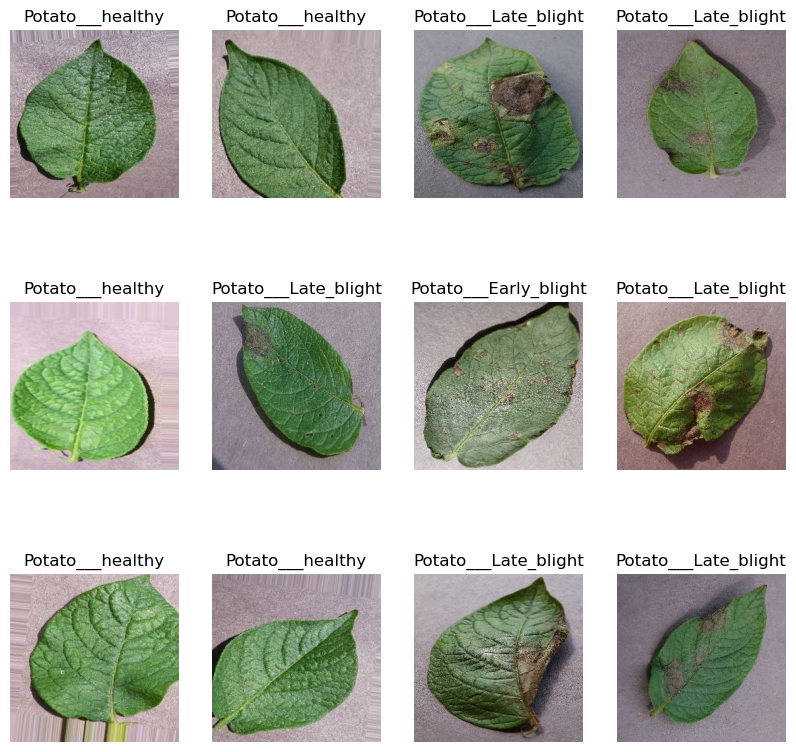

In [6]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [7]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size=len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size, seed=12)
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)
    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds
train_ds, val_ds, test_ds=get_dataset_partitions_tf(dataset)

In [8]:
print(len(train_ds), len(val_ds), len(test_ds))

75 9 10


In [9]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [10]:
resize_and_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [11]:
input_shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes=3
model=models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])
model.build(input_shape=input_shape)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (16, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (16, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (16, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (16, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (16, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (16, 62, 62, 64)         0         
 2D)                                                  

In [14]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)
history=model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/20
75/75 [==============================] - 48s 617ms/step - loss: 0.1430 - accuracy: 0.9473 - val_loss: 0.0400 - val_accuracy: 0.9861
Epoch 2/20
75/75 [==============================] - 47s 631ms/step - loss: 0.1029 - accuracy: 0.9682 - val_loss: 0.0621 - val_accuracy: 0.9722
Epoch 3/20
75/75 [==============================] - 47s 630ms/step - loss: 0.1043 - accuracy: 0.9582 - val_loss: 0.0406 - val_accuracy: 0.9861
Epoch 4/20
75/75 [==============================] - 47s 628ms/step - loss: 0.1017 - accuracy: 0.9699 - val_loss: 0.0313 - val_accuracy: 0.9931
Epoch 5/20
75/75 [==============================] - 47s 622ms/step - loss: 0.1074 - accuracy: 0.9574 - val_loss: 0.3007 - val_accuracy: 0.9167
Epoch 6/20
75/75 [==============================] - 47s 632ms/step - loss: 0.1186 - accuracy: 0.9523 - val_loss: 0.0621 - val_accuracy: 0.9722
Epoch 7/20
75/75 [==============================] - 48s 637ms/step - loss: 0.0752 - accuracy: 0.9749 - val_loss: 0.0693 - val_accuracy: 0.9583

In [15]:
scores=model.evaluate(test_ds)
scores

10/10 [==============================] - 2s 113ms/step - loss: 0.0452 - accuracy: 0.9812


[0.045248664915561676, 0.981249988079071]

In [16]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [17]:
history.history['loss']

[0.1429772973060608,
 0.10287626087665558,
 0.10434138029813766,
 0.10169731825590134,
 0.10736784338951111,
 0.11863384395837784,
 0.07515323907136917,
 0.07800349593162537,
 0.0865444615483284,
 0.11569792032241821,
 0.06780274212360382,
 0.05280375853180885,
 0.060067277401685715,
 0.06612404435873032,
 0.07425224781036377,
 0.06476665288209915,
 0.08506424725055695,
 0.05349591001868248,
 0.04317128285765648,
 0.04711923375725746]

In [18]:
history.history['accuracy']

[0.9473243951797485,
 0.9682274460792542,
 0.9581939578056335,
 0.9698996543884277,
 0.9573578834533691,
 0.9523411393165588,
 0.974916398525238,
 0.9715719223022461,
 0.9665551781654358,
 0.9623745679855347,
 0.974916398525238,
 0.9841136932373047,
 0.9757525324821472,
 0.97826087474823,
 0.9799330830574036,
 0.9849498271942139,
 0.9698996543884277,
 0.9807692170143127,
 0.9841136932373047,
 0.9841136932373047]

In [19]:
history.history['val_loss']

[0.04000307619571686,
 0.06208186596632004,
 0.04057012498378754,
 0.031314603984355927,
 0.3007276654243469,
 0.06205503270030022,
 0.06928060203790665,
 0.02661050111055374,
 0.23966529965400696,
 0.09132823348045349,
 0.014344321563839912,
 0.05184396356344223,
 0.014532748609781265,
 0.018478991463780403,
 0.031423408538103104,
 0.009807606227695942,
 0.02640659734606743,
 0.017593778669834137,
 0.03820201754570007,
 0.009678201749920845]

In [20]:
history.history['val_accuracy']

[0.9861111044883728,
 0.9722222089767456,
 0.9861111044883728,
 0.9930555820465088,
 0.9166666865348816,
 0.9722222089767456,
 0.9583333134651184,
 0.9861111044883728,
 0.9305555820465088,
 0.9583333134651184,
 1.0,
 0.9722222089767456,
 1.0,
 0.9930555820465088,
 0.9861111044883728,
 1.0,
 0.9861111044883728,
 0.9930555820465088,
 0.9722222089767456,
 1.0]

In [21]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

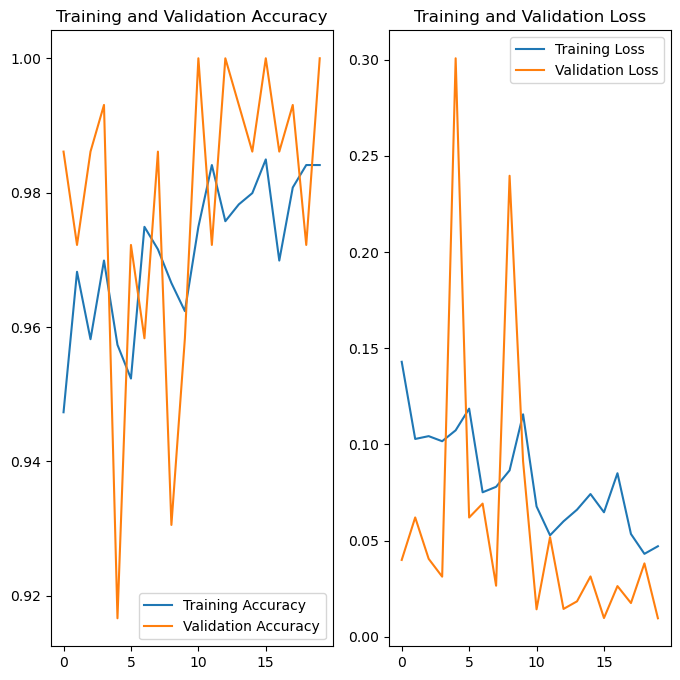

In [22]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

In [23]:
true_labels = []
pred_labels = []
for images_batch, labels_batch in test_ds.take(10):
    batch_prediction=model.predict(images_batch).argmax(axis=1)
    for i in labels_batch:
        true_labels.append(i)
    for i in batch_prediction:
        pred_labels.append(i)

1/1 [==============================] - 0s 201ms/step


In [24]:
def predict(model, img):
    img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array=tf.expand_dims(img_array,0)
    predictions=model.predict(img_array)
    predicted_class=class_names[np.argmax(predictions[0])]
    confidence=round(100*(np.max(predictions[0])),2)
    return predicted_class, confidence

1/1 [==============================] - 0s 27ms/step


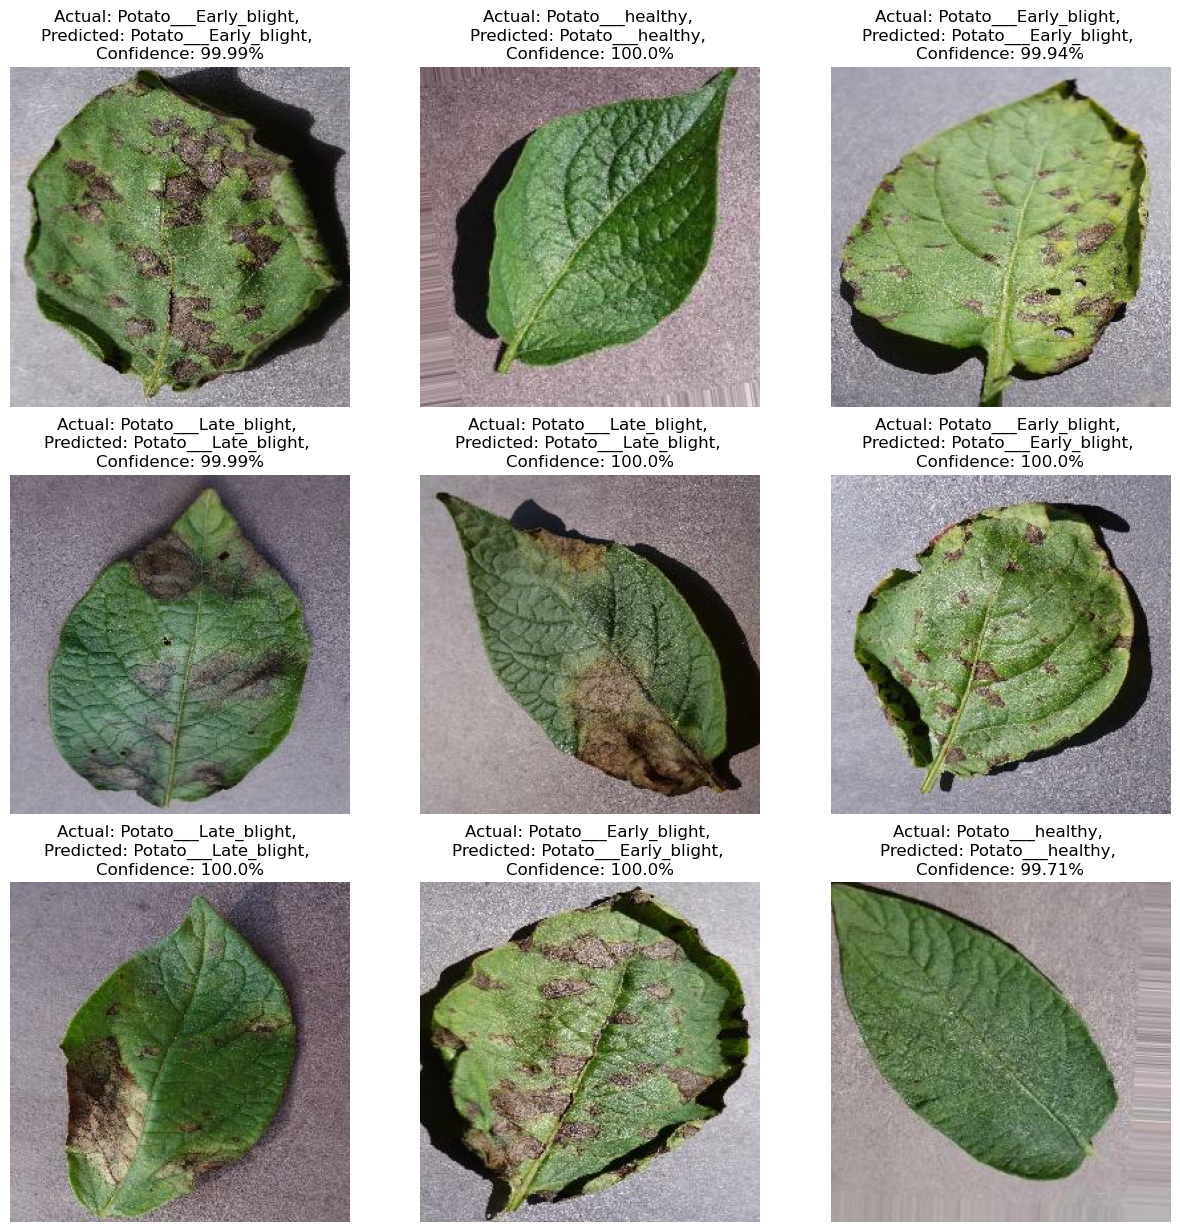

In [25]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence=predict(model,images[i].numpy())
        actual_class=class_names[labels[i]]
        plt.title(f"Actual: {actual_class}, \nPredicted: {predicted_class}, \nConfidence: {confidence}%")
        plt.axis("off")

In [26]:
print ("Classification Report: \n", classification_report(true_labels, pred_labels))

Classification Report: 
               precision    recall  f1-score   support

           0       0.94      1.00      0.97        48
           1       1.00      0.95      0.97        61
           2       1.00      1.00      1.00        51

    accuracy                           0.98       160
   macro avg       0.98      0.98      0.98       160
weighted avg       0.98      0.98      0.98       160



In [27]:
cm=tf.math.confusion_matrix(true_labels, pred_labels)
cm

<tf.Tensor: shape=(3, 3), dtype=int32, numpy=
array([[48,  0,  0],
       [ 3, 58,  0],
       [ 0,  0, 51]])>

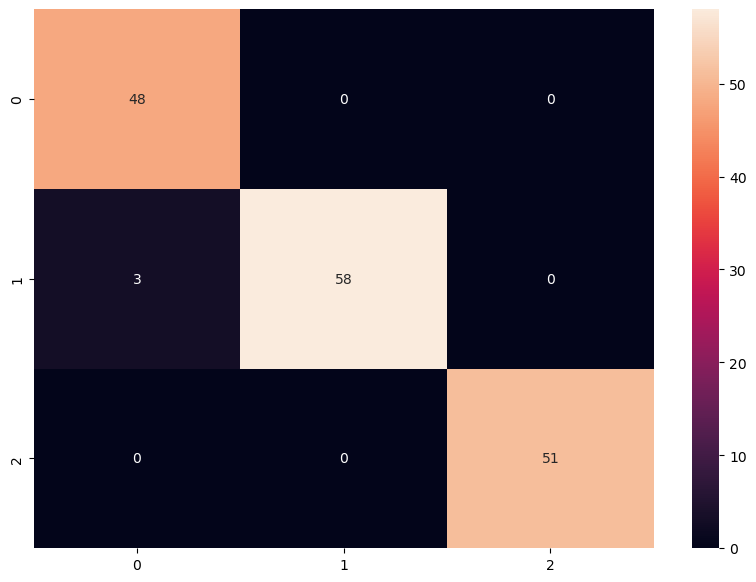

In [28]:
plt.figure(figsize=(10,7))
sn.heatmap(cm,annot=True,fmt='d')
plt.xlabel=('Predicted')
plt.ylabel=('Truth')

In [29]:
filename = "Model1-2-BatchSize16.joblib"
joblib.dump(model, filename)

['Model1-2-BatchSize16.joblib']